# Explore SpeechBrain: Voice Activation Detection

This notebook will explore voice activation detection (VAD) using the Python library [SpeechBrain](https://speechbrain.github.io/index.html). `SpeechBrain` can be installed with `pip install speechbrain`. To run the notebook for the first time, it must be opened with administrator rights.

In [1]:
""" Explore speechbrain voice activation detection """
import matplotlib.pyplot as plt
import opensmile
import torch
import torchaudio
from hyperpyyaml.core import (dump_hyperpyyaml, load_hyperpyyaml)
from IPython.display import Audio
from speechbrain.pretrained import VAD

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


## Single Speaker

As a test case for a single speaker, a part of the victory speech by the current president of the United States Joe Biden will be used ([link](https://www.englishspeecheschannel.com/english-speeches/joe-biden-speech/) to full speech). This audio file is located at `/audio`.

In [2]:
def plot_audio(filename):
    """ Plots an audio signal from a file with the audio player interface """
    signal, fs = torchaudio.load(filename)
    signal = signal.squeeze()

    time = torch.linspace(0, signal.shape[0]/fs, steps=signal.shape[0])

    plt.plot(time, signal)

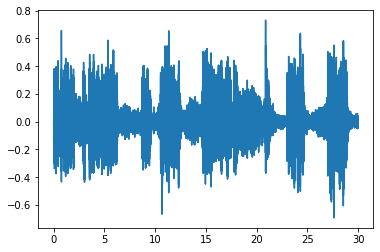

In [3]:
FILENAME_SINGLE = "audio/test_audio_single.wav"

plot_audio(FILENAME_SINGLE)

Audio(FILENAME_SINGLE)

In [4]:
VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty",
                       savedir="pretrained_models/vad-crdnn-libriparty")

In `pretrained_models/vad-crdnn-libriparty/hyperparams.yaml`, the argument `sample_rate` needs to be set to 48000 to match the resolution of the example file. Moreover, the argument `n_fft` is set to 1200 to comply with the resolution. This should be automated with `hyperpyyaml.core.load_hyperpyyaml()` and `hyperpyyaml.core.dump_hyperpyyaml()`, however, the letter function produces an error when trying to represent classes. In `hyperpyyaml`, classes are preceded by a `!` operator. During `load_hyperpyyaml()`, the classes are created in the returned dicitionary (i.e., `hyperparams`). During `dump_hyperpyyaml()`, this operation is not reversed, i.e., the classes are not converted back to `hyperpyyaml` format (preceded by `!`). Another step in between seems necessary for the back conversion.

In [5]:
def update_hyperparams(filename, overrides):
    """ Loads hyperpyyaml file, override parameters, and dumps the file again (does not work currently!) """
    with open(filename, "r+") as stream:
        hyperparams = load_hyperpyyaml(
            stream, overrides=overrides, overrides_must_match=True)
        dump_hyperpyyaml(hyperparams, stream)

In [6]:
try: 
    update_hyperparams("pretrained_models/vad-crdnn-libriparty/hyperparams.yaml",
                       {"sample_rate": 48000, "n_fft": 1200})
except Exception as e:
    print(e)

cannot represent an object: functools.partial(<class 'torch.nn.modules.activation.LeakyReLU'>)


In [7]:
def detect_voice_activation(filename, vad):
    """
    Extracts voice activation (speech) segments from an audio file using a neural VAD model:
    Computes posterior probability for speech segments from neural VAD model.
    Applies a threshold on the posterior probability to get candidate segments.
    Extracts speech segments using energy-based VAD.
    Merges segments that are close to each other.
    Removes short segments.
    Double check the energy-based VAD using the neural VAD model.
    """
    prob_chunks = vad.get_speech_prob_file(filename)
    prob_th = vad.apply_threshold(
        prob_chunks, activation_th=0.5, deactivation_th=0.25).float()
    boundaries = vad.get_boundaries(prob_th)
    boundaries_energy = vad.energy_VAD(
        filename, boundaries, activation_th=0.8, deactivation_th=0.0)
    boundaries_merged = vad.merge_close_segments(
        boundaries_energy, close_th=0.250)
    boundaries_short_removed = vad.remove_short_segments(
        boundaries_merged, len_th=0.250)
    boundaries_checked = vad.double_check_speech_segments(
        boundaries_short_removed, filename,  speech_th=0.5)

    return [boundaries, boundaries_energy, boundaries_merged, boundaries_short_removed, boundaries_checked]

In [8]:
def upsample_boundaries_list(boundaries_list, filename, vad):
    """ Upsamples multiple voice activation boundaries from a list """
    upsampled_boundaries_list = []

    for i, boundaries in enumerate(boundaries_list):
        upsampled_boundaries_list.append(
            vad.upsample_boundaries(boundaries, filename))

    return upsampled_boundaries_list

In [9]:
def plot_voice_activation(filename, boundaries_list):
    """ Plots detected voice activation (speech) segments """
    wave, fs = torchaudio.load(filename)
    signal = wave.squeeze()
    time = torch.linspace(0, signal.shape[0]/fs, steps=signal.shape[0])

    labels = ["Posterior", "Energy", "Merged",
              "Short removed", "Double-checked"]

    plt.plot(time, signal)

    for i, boundaries in enumerate(boundaries_list):
        new_boundaries = boundaries.squeeze() if i % 2 == 0 else boundaries.squeeze()*-1
        plt.plot(time,  new_boundaries, label=labels[i])

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [10]:
boundaries_list_single = detect_voice_activation(FILENAME_SINGLE, VAD)
VAD.save_boundaries(boundaries_list_single[-1])

segment_001  0.00  0.04 NON_SPEECH
segment_002  0.04  6.34 SPEECH
segment_003  6.34  8.70 NON_SPEECH
segment_004  8.70  9.59 SPEECH
segment_005  9.59  10.54 NON_SPEECH
segment_006  10.54  12.61 SPEECH
segment_007  12.61  14.69 NON_SPEECH
segment_008  14.69  18.16 SPEECH
segment_009  18.16  20.20 NON_SPEECH
segment_010  20.20  21.83 SPEECH
segment_011  21.83  23.01 NON_SPEECH
segment_012  23.01  25.10 SPEECH
segment_013  25.10  27.02 NON_SPEECH
segment_014  27.02  29.16 SPEECH


In [11]:
upsampled_boundaries_list_single = upsample_boundaries_list(
    boundaries_list_single, FILENAME_SINGLE, VAD)

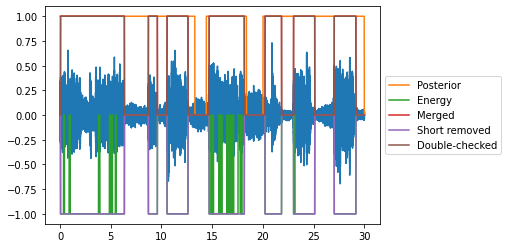

In [12]:
plot_voice_activation(FILENAME_SINGLE, upsampled_boundaries_list_single)

The voice activation detection seems accurate given the audio signal. In the first segment, there might be a non-speech part that was missed (around 2.5-3s).

In [13]:
def extract_voice_prob_opensmile(filename):
    """ Extracts voice probability using opensmile """
    extractor_custom = opensmile.Smile(
        feature_set="custom.conf",
        feature_level="pitch_acf"
    )

    voice_prob = extractor_custom.process_file(filename)["voiceProb"]

    return voice_prob

In [14]:
def create_voice_activation_boundaries_opensmile(voice_prob):
    """ Creates speech segment boundaries from opensmile voice probabilities """
    segments = []
    tmp = False
    for i, frame in voice_prob.reset_index().iterrows():
        time = frame["start"].total_seconds()
        if frame["voiceProb"] >= 0.5 and not tmp:
            tmp = True
            segments.append([time])
        elif frame["voiceProb"] < 0.25 and tmp:
            tmp = False
            segments[-1].append(time)

    if len(segments[-1]) == 1:
        segments[-1].append(time)

    return torch.tensor(segments)

In [15]:
def detect_voice_activation_opensmile(filename):
    """ Wrapper for opensmile voice activation detection """
    voice_prob = extract_voice_prob_opensmile(filename)

    boundaries = create_voice_activation_boundaries_opensmile(voice_prob)

    return boundaries

In [16]:
boundaries_opensmile_single = detect_voice_activation_opensmile(
    FILENAME_SINGLE)

In [17]:
def compare_voice_activation_opensmile(filename, boundaries_speechbrain, boundaries_opensmile):
    """ Compare voice activation segments from speechbrain and opensmile """
    wave, fs = torchaudio.load(filename)
    signal = wave.squeeze()
    time = torch.linspace(0, signal.shape[0]/fs, steps=signal.shape[0])

    labels = ["SpeechBrain posterior", "openSMILE"]

    plt.plot(time, signal)

    for i, boundaries in enumerate([boundaries_speechbrain, boundaries_opensmile]):
        plt.plot(time,  boundaries.squeeze() if i ==
                 0 else boundaries.squeeze()*-1, label=labels[i])

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

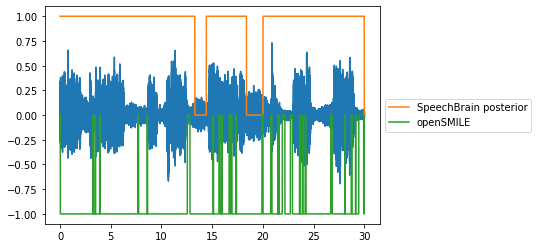

In [18]:
compare_voice_activation_opensmile(FILENAME_SINGLE, upsampled_boundaries_list_single[0], VAD.upsample_boundaries(
    boundaries_opensmile_single, FILENAME_SINGLE))

Note that the posterior probability segments are shown for SpeechBrain. openSMILE seems to detect much more fine-grained speech segments compared to SpeechBrain. It may need further preprocessing as done in the SpeechBrain pipeline.

## Multiple Speakers

As a test case for multiple speakers, a part of a presidential debate in the United States 2020  will be used ([link](https://www.englishspeecheschannel.com/english-speeches/us-presidential-debates-2020/) to full speech). The audio file is located at `/audio`.

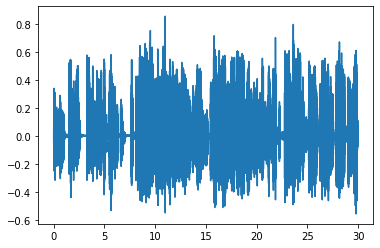

In [19]:
FILENAME_MULTI = "audio/test_audio_multi.wav"

plot_audio(FILENAME_MULTI)

Audio(FILENAME_MULTI)

In [20]:
boundaries_list_multi = detect_voice_activation(FILENAME_MULTI, VAD)
VAD.save_boundaries(boundaries_list_multi[-1])

segment_001  0.00  0.04 NON_SPEECH
segment_002  0.04  1.05 SPEECH
segment_003  1.05  1.54 NON_SPEECH
segment_004  1.54  2.62 SPEECH
segment_005  2.62  3.29 NON_SPEECH
segment_006  3.29  5.23 SPEECH
segment_007  5.23  5.51 NON_SPEECH
segment_008  5.51  6.32 SPEECH
segment_009  6.32  7.65 NON_SPEECH
segment_010  7.65  20.74 SPEECH
segment_011  20.74  21.18 NON_SPEECH
segment_012  21.18  21.90 SPEECH
segment_013  21.90  22.78 NON_SPEECH
segment_014  22.78  24.45 SPEECH
segment_015  24.45  25.13 NON_SPEECH
segment_016  25.13  27.58 SPEECH
segment_017  27.58  27.86 NON_SPEECH
segment_018  27.86  28.74 SPEECH
segment_019  28.74  29.02 NON_SPEECH
segment_020  29.02  29.96 SPEECH


In [21]:
upsampled_boundaries_list_multi = upsample_boundaries_list(
    boundaries_list_multi, FILENAME_MULTI, VAD)

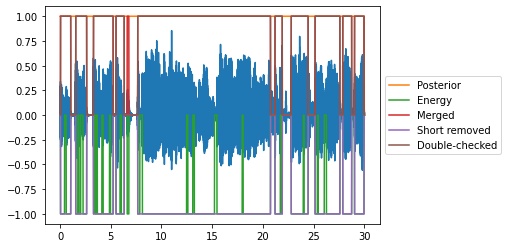

In [22]:
plot_voice_activation(FILENAME_MULTI, upsampled_boundaries_list_multi)

In [23]:
boundaries_opensmile_multi = detect_voice_activation_opensmile(FILENAME_MULTI)

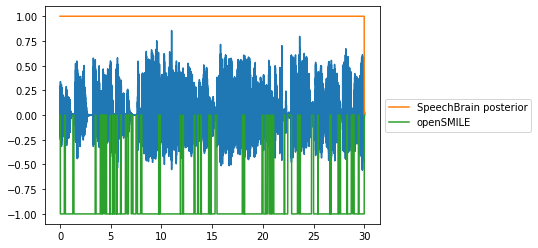

In [24]:
compare_voice_activation_opensmile(FILENAME_MULTI, upsampled_boundaries_list_multi[0], VAD.upsample_boundaries(
    boundaries_opensmile_multi, FILENAME_MULTI))

Whereas SpeechBrain classifies the entire signal as one speech segment based on posterior probability, openSMILE produces very fine-grained segments. Both require further preprocessing as done in the SpeechBrain pipeline.